In [83]:
import geopandas as gpd
import pandas as pd
import urbanpy as up
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.merge import merge
from rasterstats import zonal_stats
from fiona.crs import from_epsg

In [2]:
cp_osiptel = gpd.read_file('inputs/cp_osiptel/')

In [3]:
cp_osiptel.head()

Name descriptio timestamp begin   end altitudeMo  \
0  0101010001 CHACHAPOYAS       None      None  None  None       None   
1      0101080001 HUANCAS       None      None  None  None       None   
2     0101090001 LA JALCA       None      None  None  None       None   
3   0101100001 LEIMEBAMBA       None      None  None  None       None   
4        0102010001 BAGUA       None      None  None  None       None   

   tessellate  extrude  visibility drawOrder  icon  \
0           1        0          -1      None  None   
1           1        0          -1      None  None   
2           1        0          -1      None  None   
3           1        0          -1      None  None   
4           1        0          -1      None  None   

                              layer  \
0  BD_POLIGONOS_2020 POLIGONOS 2020   
1  BD_POLIGONOS_2020 POLIGONOS 2020   
2  BD_POLIGONOS_2020 POLIGONOS 2020   
3  BD_POLIGONOS_2020 POLIGONOS 2020   
4  BD_POLIGONOS_2020 POLIGONOS 2020   

                                                path  \
0  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...   
1  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...   
2  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...   
3  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...   
4  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...   

                                            geometry  
0  POLYGON Z ((-77.85908 -6.23989 0.00000, -77.86...  
1  POLYGON Z ((-77.86513 -6.17532 0.00000, -77.86...  
2  POLYGON Z ((-77.81752 -6.49083 0.00000, -77.81...  
3  POLYGON Z ((-77.80682 -6.70533 0.00000, -77.80...  
4  POLYGON Z ((-78.52976 -5.64313 0.00000, -78.53...

## Population

In [4]:
mzn_peru = gpd.read_file('outputs/manzanas_censales_peru.geojson', driver='GeoJSON')

In [5]:
mzn_peru.head()

Mz  UBIGEO AREA CODCCPP   ZONA MANZANA_ID MANZANA_A  \
0  150118000103900034R  150118    1    0001  03900        034         R   
1   150118000104100025  150118    1    0001  04100        025      None   
2  150118000104400020A  150118    1    0001  04400        020         A   
3  150118000100800020B  150118    1    0001  00800        020         B   
4  150118000104901001D  150118    1    0001  04901        001         D   

   T_TOTAL  T_HOMBRES  T_MUJERES  ...      Apellido CCDD CCPP  CCDI  \
0     14.0        8.0        6.0  ...  Suyo Pomalía   15   01    18   
1     96.0       42.0       54.0  ...  Suyo Pomalía   15   01    18   
2     48.0       28.0       20.0  ...  Suyo Pomalía   15   01    18   
3      2.0        1.0        1.0  ...  Suyo Pomalía   15   01    18   
4      6.0        1.0        5.0  ...  Suyo Pomalía   15   01    18   

     NOMBDIST  CAPITAL  CODIGO CNT_CCPP  DESCRIPCIO  \
0  LURIGANCHO  CHOSICA  150118      1.0  LURIGANCHO   
1  LURIGANCHO  CHOSICA  150118      1.0  LURIGANCHO   
2  LURIGANCHO  CHOSICA  150118      1.0  LURIGANCHO   
3  LURIGANCHO  CHOSICA  150118      1.0  LURIGANCHO   
4  LURIGANCHO  CHOSICA  150118      1.0  LURIGANCHO   

                                            geometry  
0  POLYGON ((-76.91235 -11.97819, -76.91179 -11.9...  
1  POLYGON ((-76.90736 -11.98098, -76.90756 -11.9...  
2  POLYGON ((-76.93393 -12.00191, -76.93359 -12.0...  
3  POLYGON ((-76.69330 -11.93502, -76.69324 -11.9...  
4  POLYGON ((-76.96480 -11.99497, -76.96487 -11.9...  

[5 rows x 29 columns]

In [6]:
cp_osiptel_pop = up.geom.merge_shape_hex(cp_osiptel, mzn_peru, agg={'T_TOTAL': 'sum',
                                                                    'T_HOMBRES': 'sum',
                                                                    'T_MUJERES': 'sum'})

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
minx, miny, maxx, maxy = mzn_peru[mzn_peru['NOMBPROV'] == 'LIMA'].total_bounds

<AxesSubplot:>

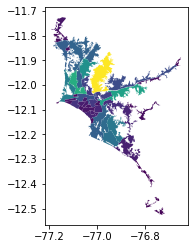

In [13]:
cp_osiptel_pop.cx[minx:maxx, miny:maxy].plot('T_TOTAL')

In [14]:
# Check CP per Department
if False:
    for dep in mzn_peru['NOMBDEP'].unique():
        minx, miny, maxx, maxy = mzn_peru[mzn_peru['NOMBDEP'] == dep].total_bounds
        print(dep)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
        cp_osiptel_pop.cx[minx:maxx, miny:maxy].plot('T_TOTAL', ax=ax1)
        cp_osiptel_pop.cx[minx:maxx, miny:maxy].plot('T_MUJERES', ax=ax2)
        cp_osiptel_pop.cx[minx:maxx, miny:maxy].plot('T_HOMBRES', ax=ax3)
        plt.show()

## Altitude

We have downloaded a DEM from https://search.earthdata.nasa.gov/ in raster format

In [15]:
raster_bounds_peru_gdf = gpd.read_file('outputs/raster_bounds_peru.geojson', driver='GeoJSON')

In [41]:
raster_n_cp = raster_bounds_peru_gdf.sjoin(cp_osiptel, how='inner', predicate='intersects')

In [42]:
raster_n_cp.shape, raster_bounds_peru_gdf.shape

((1225, 16), (147, 2))

In [43]:
raster_n_cp.head()

filename  \
0   outputs/DEM_rasters/ASTGTMV003_S18W073_dem.tif   
88  outputs/DEM_rasters/ASTGTMV003_S18W072_dem.tif   
91  outputs/DEM_rasters/ASTGTMV003_S17W073_dem.tif   
0   outputs/DEM_rasters/ASTGTMV003_S18W073_dem.tif   
91  outputs/DEM_rasters/ASTGTMV003_S17W073_dem.tif   

                                             geometry  index_right  \
0   POLYGON ((-73.00014 -18.00014, -73.00014 -16.9...          967   
88  POLYGON ((-72.00014 -18.00014, -72.00014 -16.9...          967   
91  POLYGON ((-73.00014 -17.00014, -73.00014 -15.9...          967   
0   POLYGON ((-73.00014 -18.00014, -73.00014 -16.9...          971   
91  POLYGON ((-73.00014 -17.00014, -73.00014 -15.9...          971   

                           Name descriptio timestamp begin   end altitudeMo  \
0           0407010001 MOLLENDO       None      None  None  None       None   
88          0407010001 MOLLENDO       None      None  None  None       None   
91          0407010001 MOLLENDO       None      None  None  None       None   
0   0407040001 ISLAY (MATARANI)       None      None  None  None       None   
91  0407040001 ISLAY (MATARANI)       None      None  None  None       None   

    tessellate  extrude  visibility drawOrder  icon  \
0            1        0          -1      None  None   
88           1        0          -1      None  None   
91           1        0          -1      None  None   
0            1        0          -1      None  None   
91           1        0          -1      None  None   

                                    layer  \
0   BD_POLIGONOS_2020 POLIGONOS 2020 (#4)   
88  BD_POLIGONOS_2020 POLIGONOS 2020 (#4)   
91  BD_POLIGONOS_2020 POLIGONOS 2020 (#4)   
0   BD_POLIGONOS_2020 POLIGONOS 2020 (#4)   
91  BD_POLIGONOS_2020 POLIGONOS 2020 (#4)   

                                                 path  
0   /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...  
88  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...  
91  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...  
0   /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...  
91  /Users/claudio/Downloads/BD_POLIGONOS_2020.kml...

In [45]:
raster_cp_list = raster_n_cp.groupby('filename')['index_right'].apply(list)

In [51]:
cp_raster_list = raster_n_cp.groupby('index_right')['filename'].apply(list)

In [52]:
cp_raster_list.apply(len).value_counts()

1    1120
2      49
4       1
3       1
Name: filename, dtype: int64

In [57]:
cp_raster_list

index_right
0       [outputs/DEM_rasters/ASTGTMV003_S07W078_dem.tif]
1       [outputs/DEM_rasters/ASTGTMV003_S07W078_dem.tif]
2       [outputs/DEM_rasters/ASTGTMV003_S07W078_dem.tif]
3       [outputs/DEM_rasters/ASTGTMV003_S07W078_dem.tif]
4       [outputs/DEM_rasters/ASTGTMV003_S06W079_dem.tif]
                              ...                       
1166    [outputs/DEM_rasters/ASTGTMV003_S13W075_dem.tif]
1167    [outputs/DEM_rasters/ASTGTMV003_S13W075_dem.tif]
1168    [outputs/DEM_rasters/ASTGTMV003_S13W076_dem.tif]
1169    [outputs/DEM_rasters/ASTGTMV003_S13W076_dem.tif]
1170    [outputs/DEM_rasters/ASTGTMV003_S13W075_dem.tif]
Name: filename, Length: 1171, dtype: object

In [78]:
from tqdm.auto import tqdm
import time

In [87]:
start = time.time()
zs_list = []
for cp_ix, raster_fns in tqdm(cp_raster_list.iteritems(), total=cp_raster_list.shape[0]):
    
    if len(raster_fns) == 1:
        src = rasterio.open(raster_fns[0], nodata=0)
        array = src.read(1)
        affine = src.transform 

    if len(raster_fns) > 1:
        dest, affine = merge([rasterio.open(fn, nodata=0) for fn in raster_fns])
        array = dest[0]

    zs = zonal_stats(
        cp_osiptel_pop.loc[[cp_ix]], 
        array,
        affine=affine,
        nodata=0,
        stats=['min', 'max', 'mean', 'median']
    )
    
    zs_list.append(zs)

dur = time.time() - start
print('Elapsed time:', dur, 'seconds')

  0%|          | 0/1171 [00:00<?, ?it/s]

Elapsed time: 295.1309287548065 seconds


In [96]:
zs_df = pd.DataFrame.from_records([zs[0] for zs in zs_list])

In [97]:
zs_df.isna().sum()

min       0
max       0
mean      0
median    0
dtype: int64

In [98]:
zs_df.columns = ['_'.join(['elevation', col]) for col in zs_df.columns]

In [99]:
zs_df.head()

elevation_min  elevation_max  elevation_mean  elevation_median
0         2199.0         2553.0     2369.246982            2364.0
1         2543.0         2631.0     2594.561086            2596.0
2         2780.0         2867.0     2826.951807            2826.0
3         2175.0         2290.0     2215.063348            2207.0
4          375.0          564.0      449.056730             439.0

In [100]:
cp_osiptel_pop_elevation = pd.concat([cp_osiptel_pop, zs_df], axis=1)

In [101]:
cp_osiptel_pop_elevation.explore(column='elevation_mean')

In [102]:
cp_osiptel_pop_elevation.to_file('outputs/cp_osiptel_pop_elevation.geojson', driver='GeoJSON')
cp_osiptel_pop_elevation.to_file('outputs/cp_osiptel_pop_elevation')

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_85381/1922919737.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cp_osiptel_pop_elevation.to_file('outputs/cp_osiptel_pop_elevation')


In [106]:
cp_osiptel_pop_elevation[['T_TOTAL', 'T_MUJERES', 'T_HOMBRES']].describe().astype(int)

T_TOTAL  T_MUJERES  T_HOMBRES
count     1171       1171       1171
mean     19363       9938       9425
std      61752      31565      30199
min         94         45         49
25%       1616        802        798
50%       3038       1567       1505
75%       9423       4834       4587
max    1044662     523079     521583

In [107]:
cp_osiptel_pop_elevation[['elevation_min', 'elevation_max', 'elevation_mean', 'elevation_median']].describe().round(2)

elevation_min  elevation_max  elevation_mean  elevation_median
count        1171.00        1171.00         1171.00           1171.00
mean         1520.58        1620.72         1559.62           1557.35
std          1505.77        1526.02         1514.80           1514.52
min             1.00          13.00            6.33              6.00
25%            79.00         152.50          111.45            109.00
50%           751.00         860.00          789.49            790.50
75%          3157.00        3257.50         3195.13           3190.50
max          4880.00        5189.00         5013.35           5009.00